## 一、研究背景
## 二、目标
<font color= 'green'   face ='黑体'>建立一个能够预测基站能耗的模型，实现两个维度的输出，并且持续优化模型精度。</font>
#### 1.根据LTE、NR的话务量，预测LTE、NR的功耗；

#### 2.引入实际电费作为权重，预测整体基站的能耗、电费，指导稽核电费准确性；

#### 3.精细化设备、区域、环境温度、季节等因素，多向量提升模型精准度；

## 三、计划
#### <font color ='red'> 1.第一阶段只做基站的，（模型选型：采用pytorch逻辑回归多层网络、pytorch LSTM模型）</font>

#### <font color ='red'> 2.第二阶段做机房类的</font>
## 三、业务理解

<font color='red'>建立模型</font>，根据前期每个基站的能耗数据，和网络指标，预测后期基站的能耗情况。
根据能耗情况，引入实际电费作为权重，预测整体基站的能耗、电费，最后输出预测结果。

<font color='red'>建立web</font>,提供查询入口。

<font color='red'>应用场景一：</font>每月提供电费稽核使用。

<font color='red'>应用场景二：</font>根据模型预测结果，对比节能措施实施后的能耗，判断实际省电效果。

<font color= 'green'   face ='黑体'>建立一个能够预测基站能耗的模型，实现两个维度的输出，并且持续优化模型精度。</font>

## 四、数据准备

### （一）、LTE能耗数据准备
#### 1.华为区能耗数据2022年11月-2023年1月


In [4]:
#Import Required Package

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
%matplotlib inline

# 深度学习框架pytorch
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
#torch.set_default_device(device)
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

cpu


In [33]:
dataframe = pd.read_csv('../data/fzdata/fz_power.csv')

In [34]:
#规整化数据类型为float
dataframe[['kwh','pdcpup','pdcpdown','pdcpall','avgrrc','avgprbup','avgprbdown','rrc', 'actusers', 'maxusers']]=dataframe[['kwh','pdcpup','pdcpdown','pdcpall','avgrrc','avgprbup','avgprbdown','rrc', 'actusers', 'maxusers']].astype('float')

In [35]:
#查看各个字段的数据类型
dataframe.dtypes
#df.shape[0]

kwh           float64
pdcpup        float64
pdcpdown      float64
pdcpall       float64
avgrrc        float64
avgprbup      float64
avgprbdown    float64
rrc           float64
actusers      float64
maxusers      float64
dtype: object

In [36]:
#查看字段记录数量是否全
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426135 entries, 0 to 1426134
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   kwh         1426135 non-null  float64
 1   pdcpup      1426135 non-null  float64
 2   pdcpdown    1426135 non-null  float64
 3   pdcpall     1426135 non-null  float64
 4   avgrrc      1426135 non-null  float64
 5   avgprbup    1421957 non-null  float64
 6   avgprbdown  1421957 non-null  float64
 7   rrc         1426135 non-null  float64
 8   actusers    1426135 non-null  float64
 9   maxusers    1426135 non-null  float64
dtypes: float64(10)
memory usage: 108.8 MB


In [37]:
# 去除重复行
dataframe = dataframe.drop_duplicates(inplace=False)
#df.shape[0]

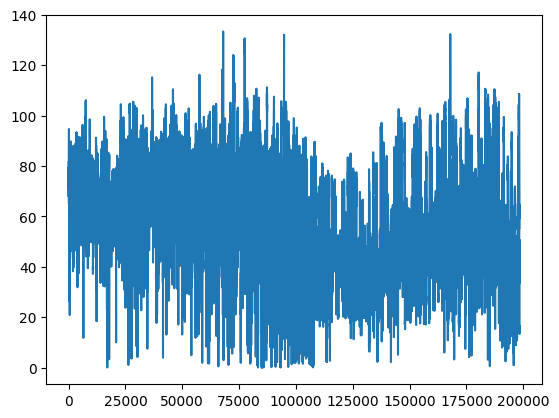

In [38]:
df = dataframe
timeseries = df[["kwh"]].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [39]:
rs = round(df[:].describe(),2)
rs

,kwh,pdcpup,pdcpdown,pdcpall,avgrrc,avgprbup,avgprbdown,rrc,actusers,maxusers
count,198411.00,198411.00,198411.00,198411.00,198411.00,197045.00,197045.00,198411.00,198411.00,198411.00
mean,57.57,45.86,441.59,487.45,166.65,25.97,34.84,24.24,7.05,48.47
std,18.35,27.11,255.81,282.18,105.06,9.29,16.84,14.15,4.59,30.35
min,0.03,0.00,0.00,0.00,0.00,4.27,1.35,0.00,0.00,0.00
25%,44.54,25.65,247.56,273.62,89.38,19.56,21.37,13.78,3.68,28.00
50%,57.41,42.54,418.52,461.44,149.07,25.14,33.39,21.97,6.16,42.00
75%,70.08,61.45,591.76,653.12,221.10,31.74,47.17,32.30,9.50,62.00
max,133.42,278.51,1783.51,1991.71,1329.14,69.28,97.08,147.68,82.31,822.00


<Axes: xlabel='pdcpup', ylabel='kwh'>

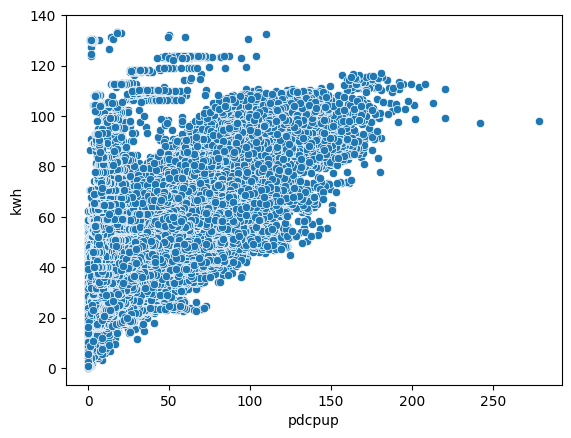

In [40]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='pdcpup', y='kwh', data=df)
# 丢掉右下角异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

<Axes: xlabel='pdcpdown', ylabel='kwh'>

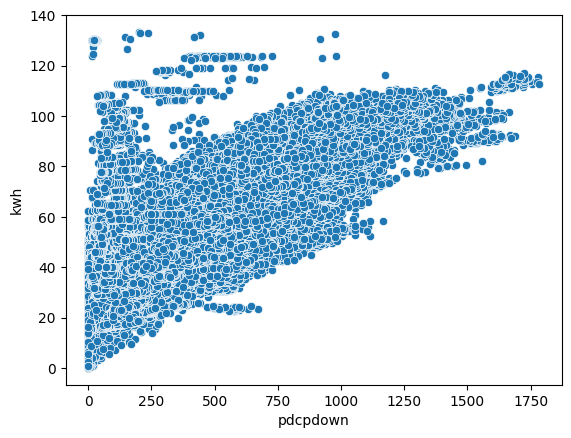

In [41]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='pdcpdown', y='kwh', data=df)
# 丢掉右下角异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

<Axes: xlabel='pdcpall', ylabel='kwh'>

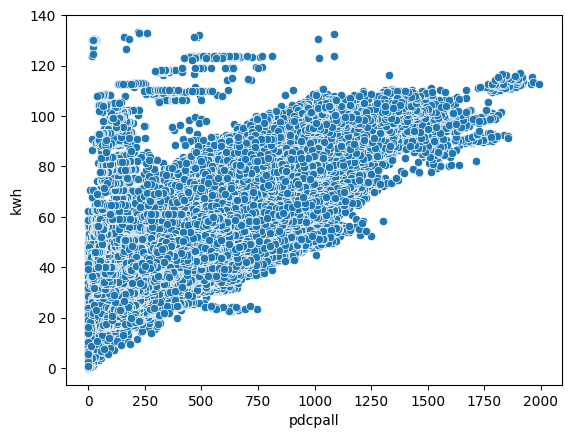

In [42]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='pdcpall', y='kwh', data=df)
# 丢掉右下角异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

<Axes: xlabel='avgrrc', ylabel='kwh'>

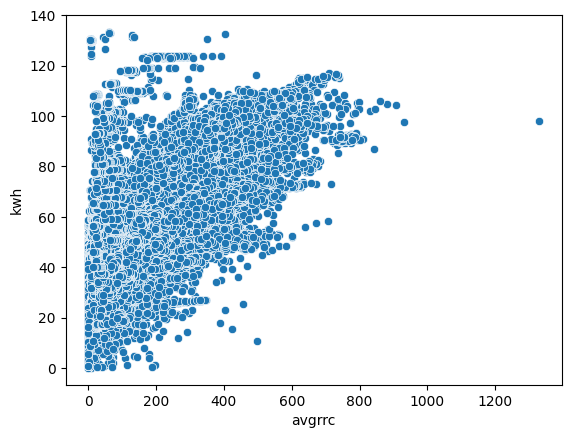

In [43]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='avgrrc', y='kwh', data=df)
# 丢掉右下角异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

<Axes: xlabel='avgprbup', ylabel='kwh'>

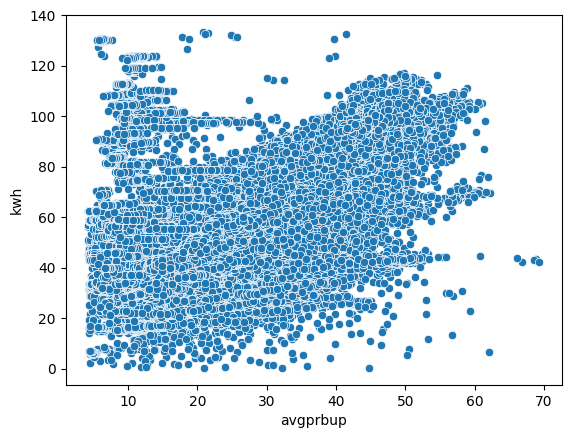

In [44]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='avgprbup', y='kwh', data=df)
# 丢掉右下角异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

<Axes: xlabel='avgprbdown', ylabel='kwh'>

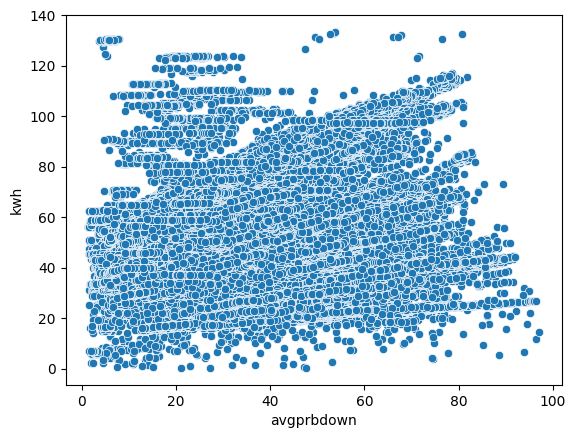

In [45]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='avgprbdown', y='kwh', data=df)
# 丢掉右下角异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

<Axes: xlabel='rrc', ylabel='kwh'>

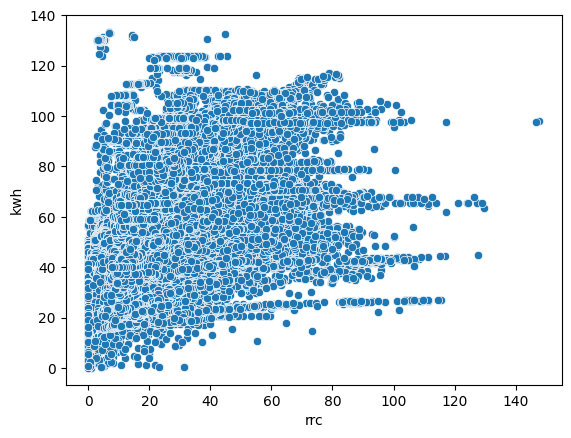

In [46]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='rrc', y='kwh', data=df)
# 丢掉右下角异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

In [47]:
dataframe=df.loc[:,'kwh':'avgprbup']
dataframe

,kwh,pdcpup,pdcpdown,pdcpall,avgrrc,avgprbup
0,78.2530,61.08,575.44,636.52,176.90,38.08
1,76.1413,58.38,563.99,622.37,173.67,38.37
2,75.0283,59.18,559.89,619.07,154.59,36.76
3,73.6997,48.64,541.47,590.11,161.46,35.54
4,74.0242,55.30,527.71,583.01,170.77,37.97
...,...,...,...,...,...,...
1425898,13.3641,0.00,0.00,0.00,0.00,NaN
1425899,13.9464,0.00,0.00,0.00,0.00,NaN
1425900,13.4597,0.00,0.00,0.00,0.00,NaN
1425901,13.8807,0.00,0.00,0.00,0.00,NaN


/tmp/ipykernel_67546/1623471585.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataframe['kwh'], ax=ax1, shade=True, color='steelblue')


<Axes: xlabel='kwh', ylabel='Frequency'>

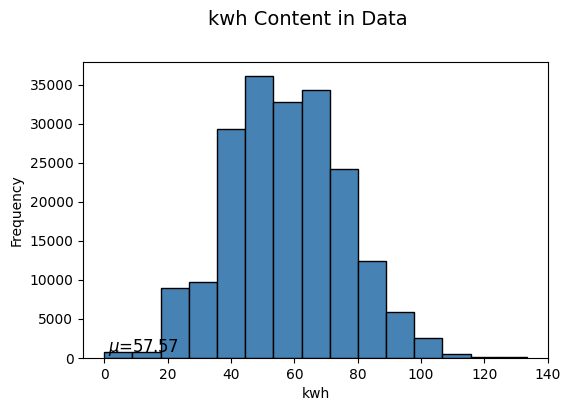

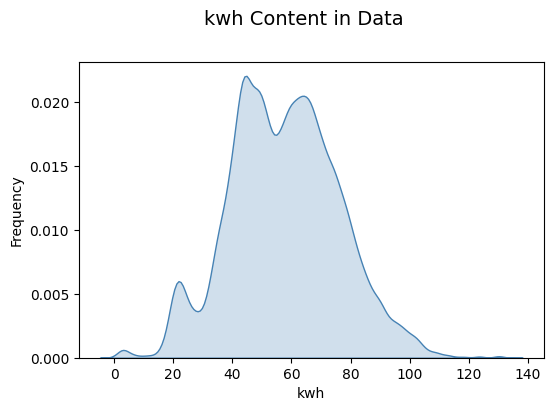

In [48]:
# Histogram
fig = plt.figure(figsize = (6,4))
title = fig.suptitle("kwh Content in Data", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("kwh")
ax.set_ylabel("Frequency") 
ax.text(1.2, 800, r'$\mu$='+str(round(df['kwh'].mean(),2)), 
         fontsize=12)
freq, bins, patches = ax.hist(dataframe['kwh'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)


# Density Plot
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("kwh Content in Data", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,1, 1)
ax1.set_xlabel("kwh")
ax1.set_ylabel("Frequency") 
sns.kdeplot(dataframe['kwh'], ax=ax1, shade=True, color='steelblue')

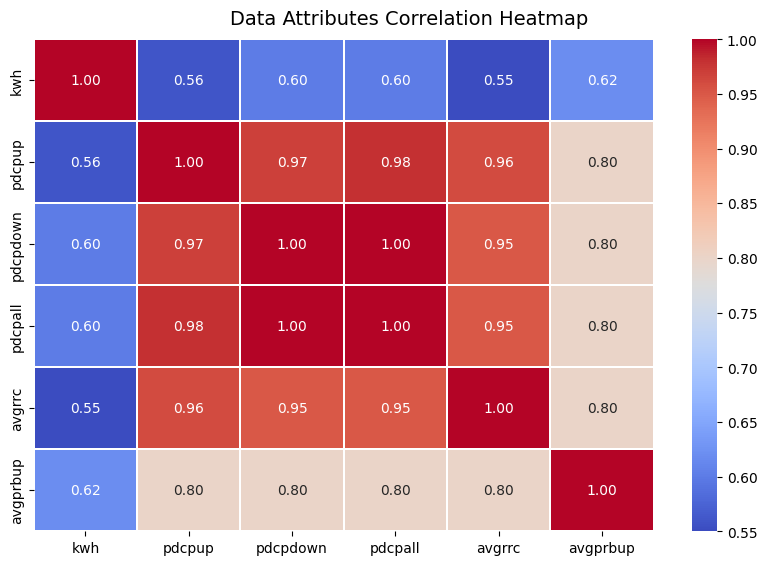

In [49]:
# Correlation Matrix Heatmap
#这里可以使用设置最大关联的前几名，可以参考网络资料设置，这里我s
f, ax = plt.subplots(figsize=(10, 6))
corr = dataframe.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Data Attributes Correlation Heatmap', fontsize=14)

In [50]:
dataframe[['kwh','pdcpup','pdcpdown','pdcpall','avgrrc','avgprbup' ]]=dataframe[['kwh','pdcpup','pdcpdown','pdcpall','avgrrc','avgprbup' ]]

In [51]:
dataframe[['kwh','pdcpup','pdcpdown','pdcpall','avgrrc','avgprbup']]=dataframe[['kwh','pdcpup','pdcpdown','pdcpall','avgrrc','avgprbup']]

In [52]:
dataset = dataframe
dataset.tail()
dataset.isna().sum()

kwh            0
pdcpup         0
pdcpdown       0
pdcpall        0
avgrrc         0
avgprbup    1366
dtype: int64

In [53]:
#去除掉数据中isna的数据
datasets=dataset.dropna(axis=0,how='any')
datasets.tail()
datasets.isna().sum()

kwh         0
pdcpup      0
pdcpdown    0
pdcpall     0
avgrrc      0
avgprbup    0
dtype: int64

In [54]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197045 entries, 0 to 1425896
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   kwh       197045 non-null  float64
 1   pdcpup    197045 non-null  float64
 2   pdcpdown  197045 non-null  float64
 3   pdcpall   197045 non-null  float64
 4   avgrrc    197045 non-null  float64
 5   avgprbup  197045 non-null  float64
dtypes: float64(6)
memory usage: 10.5 MB


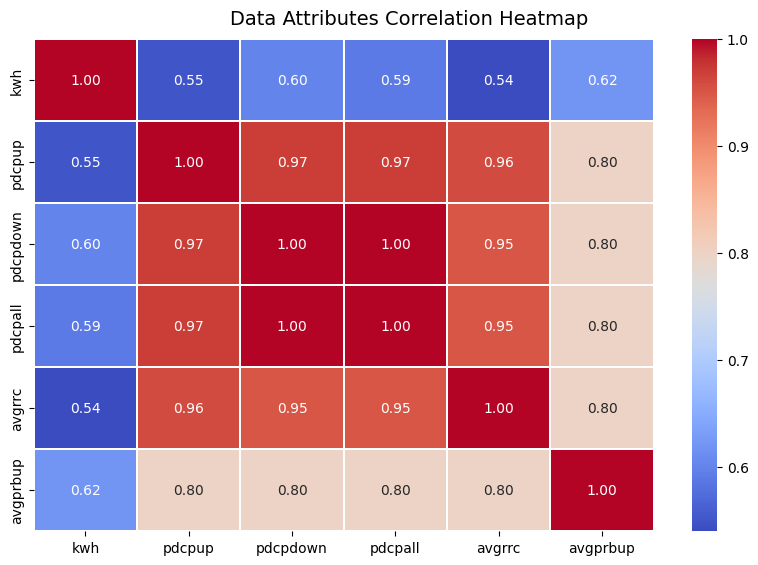

In [55]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = datasets.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Data Attributes Correlation Heatmap', fontsize=14)

In [56]:
#划分训练集和测试集
train_dataset = datasets.sample(frac=0.8,random_state=0)
test_dataset = datasets.drop(train_dataset.index)
print(train_dataset)


             kwh  pdcpup  pdcpdown  pdcpall  avgrrc  avgprbup
1140874  47.4762   34.39    316.10   350.49  111.84     22.39
252956   78.8887   64.96    715.38   780.35  201.81     40.59
718963   47.7182   17.78    131.50   149.28   49.61     17.11
1380581  46.2309   72.47    557.69   630.16  236.52     25.85
1062798  37.6355   32.08    389.40   421.48  107.47     12.12
...          ...     ...       ...      ...     ...       ...
492441   53.0862    5.19     60.62    65.81   21.39     12.37
1005913  22.4682   20.89    159.68   180.56   90.58     27.01
305862   62.9746   43.93    402.72   446.65  149.44     31.45
1078803  53.6336   48.18    450.29   498.48  170.14     23.49
723096   61.0224   26.39    222.88   249.27   68.98     21.63

[157636 rows x 6 columns]


In [57]:

train_features = torch.tensor(train_dataset.iloc[:,1:].values, dtype=torch.float32)
test_features = torch.tensor(test_dataset.iloc[:,1:].values, dtype=torch.float32)




train_labels = torch.tensor(train_dataset.kwh.values.reshape(-1, 1), dtype=torch.float32)
test_labels = torch.tensor(test_dataset.kwh.values.reshape(-1, 1), dtype=torch.float32)




print(train_features)
print(train_labels)

tensor([[ 34.3900, 316.1000, 350.4900, 111.8400,  22.3900],
        [ 64.9600, 715.3800, 780.3500, 201.8100,  40.5900],
        [ 17.7800, 131.5000, 149.2800,  49.6100,  17.1100],
        ...,
        [ 43.9300, 402.7200, 446.6500, 149.4400,  31.4500],
        [ 48.1800, 450.2900, 498.4800, 170.1400,  23.4900],
        [ 26.3900, 222.8800, 249.2700,  68.9800,  21.6300]])
tensor([[47.4762],
        [78.8887],
        [47.7182],
        ...,
        [62.9746],
        [53.6336],
        [61.0224]])


In [58]:

# Calculate mean and standard variance
# mean_a = torch.mean(train_features, dim=1)
# mean_b = torch.mean(test_features, dim=0)
 
# std_a = torch.std(train_features, dim=1)
# std_b = torch.std(test_features, dim=0)
 
# n_a = train_features.sub_(mean_a[:, None]).div_(std_a[:, None])
# n_b = (test_features - mean_b) / std_b
# print(n_a)
# print(n_b)
 

In [59]:
# Calculate mean and standard variance
# print(train_labels)
# mean_a = torch.mean(train_labels, dim=0)
# mean_b = torch.mean(test_labels, dim=0)
 
# std_a = torch.std(train_labels, dim=0)
# std_b = torch.std(test_labels, dim=0)
 
# n_a_train = train_labels.sub_(mean_a[:, None]).div_(std_a[:, None])
# n_b_test = (test_labels - mean_b) / std_b
# print(n_a_train)
# print(n_b_test)
 

In [61]:
# batch_size=256



# # 封装数据
# train_dataset = data.TensorDataset(n_a, n_a_train)

# # 加载数据
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size,generator=torch.Generator(device = 'cuda'), shuffle=True)


# # 封装数据
# test_dataset = data.TensorDataset(n_b, n_b_test)

# # 加载数据
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size,generator=torch.Generator(device = 'cuda'), shuffle=True)


NameError: name 'n_a' is not defined

In [62]:
batch_size=256




# 封装数据
train_dataset = data.TensorDataset(train_features, train_labels)

# 加载数据
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,generator=torch.Generator(device = 'cuda'), shuffle=True)


# 封装数据
test_dataset = data.TensorDataset(test_features, test_labels)

# 加载数据
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,generator=torch.Generator(device = 'cuda'), shuffle=True)


In [63]:
print(train_dataset.tensors)

(tensor([[ 34.3900, 316.1000, 350.4900, 111.8400,  22.3900],
        [ 64.9600, 715.3800, 780.3500, 201.8100,  40.5900],
        [ 17.7800, 131.5000, 149.2800,  49.6100,  17.1100],
        ...,
        [ 43.9300, 402.7200, 446.6500, 149.4400,  31.4500],
        [ 48.1800, 450.2900, 498.4800, 170.1400,  23.4900],
        [ 26.3900, 222.8800, 249.2700,  68.9800,  21.6300]]), tensor([[47.4762],
        [78.8887],
        [47.7182],
        ...,
        [62.9746],
        [53.6336],
        [61.0224]]))


In [64]:
from IPython import display 

### 多卡

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

#step1：定义通信方式和device,这里device一般用命令行的的方式
#在使用torch.distributed.launch启动时,会自动给入local_rank参数
parser = argparse.ArgumentParser()
parser.add_argument("--local_rank", type=int,default=-1)
FLAGS = parser.parse_args()
local_rank = FLAGS.local_rank
torch.cuda.set_device(local_rank)
dist.init_process_group(backend='nccl')  # nccl的后端通信方式
device = torch.device("cuda", local_rank)


In [ ]:
#step2:分发数据,很重要的一步
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=train_sampler,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, sampler=val_sampler,num_workers=2) #此处shuffle需要为False,可以自行在此之前先进行shuffle操作。



In [66]:
#编写pytorch模型


class HouseNet(nn.Module):
    def __init__(self,Din,H,Dout):
        super(HouseNet,self).__init__()
        self.hidden1 = nn.Linear(Din,H)
        self.hiddenm = nn.Linear(H,H)
        self.hidden2 = nn.Linear(H,Dout)
        
    def forward(self,x):
        out = self.hidden1(x)
        out = torch.relu(out)
        out = self.hidden2(out)
        return out

cuda


In [67]:

    
#输入特征向量是9维度的，中间隐藏层添加为100层，输出设置为1层。    
model = HouseNet(5,1000,1)

loss_fn = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

#绘图部分(测试时用，暂未用到)

x_list = []
y_list = []

def paintloss(loss ):
     
    y_list.append(loss)
    #display.clear_output(wait=True)
    plt.plot(  y_list)
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.text(2, 3, 'Loss = %.4f' % loss, fontdict={'size': 20, 'color': 'red'})
    #plt.show()
    #plt.pause(0.001)




In [68]:
target_loss =[]

 

def paintloss(loss ):
     
    
    #display.clear_output(wait=True)
    plt.plot(loss)
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.text(2, 3, 'Loss = %.4f' % loss, fontdict={'size': 20, 'color': 'red'})
    #plt.show()
    #plt.pause(0.001)

In [69]:
#编写训练

for it in range(500):
    print(it)
    for data in train_dataloader:
        x,y = data 
        #print(x)
        #print(y)
        y_pred = model(x)
        # 把跑出的值与真实值做损失函数运算
        loss = loss_fn(y_pred, y)
        #print(it,loss.item())
        #绘制损失图形
        #paintloss(loss.item() )
        # 把梯度置零
        optimizer.zero_grad()
        
        # 反向传播计算梯度值
        loss.backward()
        
        # 通过梯度下降更新参数
        optimizer.step()
        #print(loss.data )
        target_loss.append(loss.data )
        #print(target_loss)
        
#         if it%50 ==0:
#             #设置画布的大小
            
#             plt.figure(figsize=(15, 10)) 
            
#             plt.subplot(1, 2, 1)             
            
#             #表示清除当前的axes中的所有内容
#             #plt.cla()            
#             display.clear_output(wait=True)            
#             plt.plot(y.data.detach().cpu().numpy(),linewidth = 3.0)
#             plt.plot(y_pred.data.detach().cpu().numpy(), 'r-', lw=5)
#             plt.text(1, 1, 'Loss = %.4f' % loss.data, fontdict={'size': 20, 'color': 'red'})
#             plt.text(1, 2, 'Count =%.4f' % it,fontdict={'size':15,'color':'green'}) 
#             plt.title("plot 1")           
            
            
#             plt.subplot(1, 2, 2)
#             paintloss(loss.data.detach().cpu().numpy()) 
#             plt.title("plot 2")       
            
            
            
#             plt.pause(0.00001)
#paintloss(target_loss)            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [71]:
# 将Tensor List转换为NumPy数组
numpy_arrays = []
for tensor in target_loss:
    numpy_arrays.append(tensor.detach().cpu().numpy())
          

308000


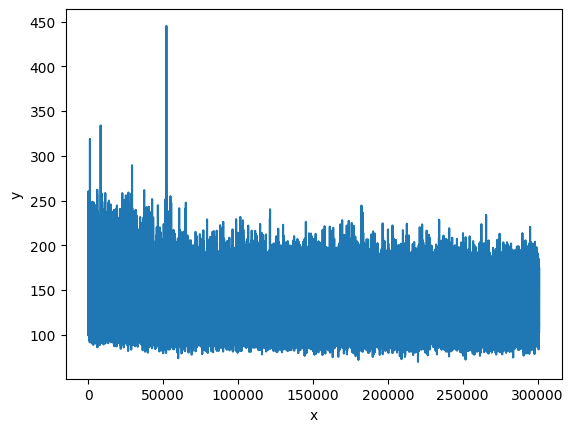

In [72]:
print(len(numpy_arrays))
paintloss(numpy_arrays[-301000:])  

In [ ]:
print(model)
for name, parameters in model.named_parameters():
    print(name, ':', parameters.size(),parameters.data)

In [73]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    #print(size)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X, y
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #print(pred.dat)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"  Avg loss: {test_loss:>8f} \n")
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [74]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
  Avg loss: 124.676799 

Epoch 2
-------------------------------
  Avg loss: 124.678377 

Epoch 3
-------------------------------
  Avg loss: 124.692498 

Epoch 4
-------------------------------
  Avg loss: 124.685042 

Epoch 5
-------------------------------
  Avg loss: 124.671395 

Epoch 6
-------------------------------
  Avg loss: 124.671567 

Epoch 7
-------------------------------
  Avg loss: 124.685407 

Epoch 8
-------------------------------
  Avg loss: 124.676190 

Epoch 9
-------------------------------
  Avg loss: 124.683574 

Epoch 10
-------------------------------
  Avg loss: 124.689885 

Epoch 11
-------------------------------
  Avg loss: 124.675942 

Epoch 12
-------------------------------
  Avg loss: 124.677031 

Epoch 13
-------------------------------
  Avg loss: 124.677263 

Epoch 14
-------------------------------
  Avg loss: 124.688923 

Epoch 15
-------------------------------
  Avg loss: 124.692946 

Epoch 16
----------

In [75]:
torch.save(model.state_dict(), "202401hwmodelor.pth")
print("Saved PyTorch Model State to 2024015hwmodelor.pth")

Saved PyTorch Model State to 2024015hwmodelor.pth


In [76]:
# 封装数据
#test_dataset = data.TensorDataset(test_features, test_labels)

# 加载数据
test_dataloader = DataLoader(test_dataset, batch_size=1,generator=torch.Generator(device = 'cuda'), shuffle=True)
print(test_dataset.tensors)

(tensor([[ 59.1800, 559.8900, 619.0700, 154.5900,  36.7600],
        [ 53.9200, 578.7000, 632.6200, 164.3800,  36.7000],
        [ 60.8600, 594.5400, 655.4100, 182.2500,  37.6200],
        ...,
        [ 31.5400, 331.2000, 362.7400, 132.2100,  23.7700],
        [ 28.8100, 298.2800, 327.0900, 124.5700,  21.2500],
        [ 29.7000, 295.3400, 325.0500, 124.6600,  21.2600]]), tensor([[75.0283],
        [75.3026],
        [78.2300],
        ...,
        [49.3884],
        [46.2624],
        [47.2725]]))


In [77]:
def tests(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    print(size)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
     
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X, y
            pred = model(X)
            comp= y-pred
            #print(torch.cat((X,y,pred),1))
            out=[torch.cat((X,y,pred,comp),1).detach().cpu().numpy()]
            newt = np.array(out)
            
            #print( newt[:][0][0])
            
            #print(np.array(out))
            #newa = 
            out2 = pd.DataFrame(newt[:][0][0])
            #print(out2)
            #print(out2.T)
            # 创建MinMaxScaler对象
            #scaler = preprocessing.MinMaxScaler()
            # 将数据进行归一化
            #df_normalized = scaler.inverse_transform(out2.values)
            # 将归一化的数据转换为数据框形式
            #datasets = pd.DataFrame(df_normalized)
            #print(dataset)
            #result = pd.concat([out],axis =0)
            #d=pd.DataFrame([torch.cat((X,y,pred),1).numpy()])
            #d
            #paintpredictS(y,pred)
            out2.T.to_csv('output.csv', mode='a', header=False, index=False)
             
    

In [78]:
tests(test_dataloader, model, loss_fn)

39409


In [82]:
#加载预测结果数据观察数据分布

df=pd.read_csv('output.csv') # 注意目录层级   
df.columns=["pdcpup","pdcpdown","pdcpall","avgrrc","avgprbup","kwh","pred","comp"]

/tmp/ipykernel_67546/1012005301.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['comp'], ax=ax1, shade=True, color='steelblue')


<Axes: xlabel='kwh', ylabel='Frequency'>

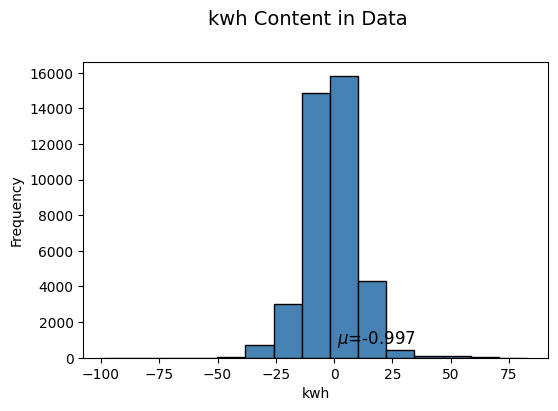

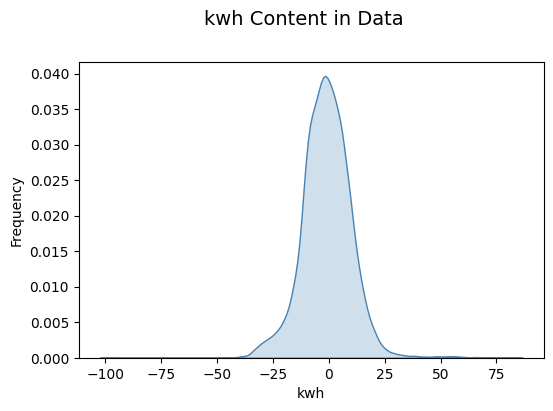

In [83]:
# Histogram
fig = plt.figure(figsize = (6,4))
title = fig.suptitle("kwh Content in Data", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("kwh")
ax.set_ylabel("Frequency") 
ax.text(1.2, 800, r'$\mu$='+str(round(df['comp'].mean(),3)), 
         fontsize=12)
freq, bins, patches = ax.hist(df['comp'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)


# Density Plot
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("kwh Content in Data", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,1, 1)
ax1.set_xlabel("kwh")
ax1.set_ylabel("Frequency") 
sns.kdeplot(df['comp'], ax=ax1, shade=True, color='steelblue')